# Project Pizza
### Class w207, Todd Holloway
### Conner Brew, Maddie DiLullo Byrne, Joy Jiang, Peter Morgan

#### Loading Packages

In [1]:
%matplotlib inline

import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

#### Loading Data

In [2]:
#Version 1: Including all of the retrieval fields
#load in training data. We will use this as both train and dev, and save 'test.json' for validation
data = pd.read_json('data/train/train.json').rename(columns = {'requester_received_pizza': 'target'})

#Change the boolean target variable to an int
data['target'] = data['target'].astype(int)

In [3]:
#Version 2: Removing retrieval fields from dataset
#Remove all columns containing information obtained at retrieval
data_nr = data.loc[:, ~data.columns.isin(data.filter(regex='retrieval').columns)]
# data_nr.columns

 #### Initial Metrics for Exploratory Elements

In [4]:
#Get a rough idea of target baseline
baseline = round(sum(data['target']) / len(data['target']), 2)
print(f'Roughly {int(baseline * 100)}% of requests receive pizza.')

Roughly 25% of requests receive pizza.


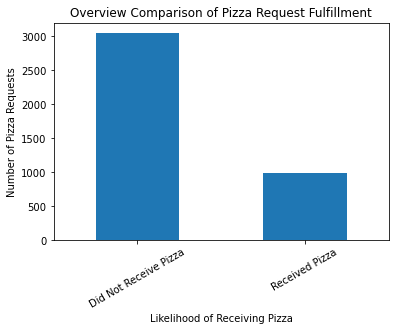

In [5]:
# Adding visual representation of the request received & ratio of those receiving pizza
plot = data['target'].value_counts(sort=False).plot.bar()
plt.xlabel("Likelihood of Receiving Pizza")
plt.ylabel("Number of Pizza Requests")
plt.title("Overview Comparison of Pizza Request Fulfillment")

labels = [item for item in plt.xticks()]
labels[0] = "Did Not Receive Pizza"
labels[1] = "Received Pizza"

plt.xticks([0, 1], ['Did Not Receive Pizza', 'Received Pizza'], rotation=30)


plt.show()

#### Random Forest Modeling & Validation

**Random Forest Calculation with Retrieval Fields**

In [6]:
#The most basic possible model - extract only int variables, no transformations
int_data = data.select_dtypes(np.number)
y = int_data['target']
X = int_data.drop('target', axis=1)

#Default randomforest with cross validation
baseline_clf = RandomForestClassifier(max_depth=5, random_state=0)
scores = cross_val_score(baseline_clf, X, y, cv=5)

In [7]:
print(f'Baseline model accuracy with retrieval fields: {round(np.mean(scores), 2) * 100}%')

Baseline model accuracy with retrieval fields: 85.0%


**Random Forest Calculation without Retrieval Fields**

In [8]:
#The most basic possible model - extract only int variables, no transformations
int_data = data_nr.select_dtypes(np.number)
y = int_data['target']
X = int_data.drop('target', axis=1)

#Default randomforest with cross validation
baseline_clf = RandomForestClassifier(max_depth=5, random_state=0)
scores = cross_val_score(baseline_clf, X, y, cv=5)

print(f'Baseline model accuracy without retrieval fields: {round(np.mean(scores), 2) * 100}%')

Baseline model accuracy without retrieval fields: 76.0%


#### Looking at the data from a unigram logistic regression perspective

In [9]:
# Load Train Data
train_data = data['request_title']
train_labels = data['target']
# I decided to dedicate 2/3rds to the training set, and 1/3rd to the dev set
twothirds = int(train_data.shape[0]*2/3)
# Splitting into the training & dev sets
dev_data = train_data[twothirds:]
dev_labels = train_labels[twothirds:]

train_data = train_data[:twothirds]
train_labels = train_labels[:twothirds]

train_data.shape, dev_data.shape

((2693,), (1347,))

In [10]:
# Load Train Data
train_data = data['request_title']
train_labels = data['target']
# I decided to dedicate 2/3rds to the training set, and 1/3rd to the dev set
twothirds = int(train_data.shape[0]*2/3)
# Splitting into the training & dev sets
dev_data = train_data[twothirds:]
dev_labels = train_labels[twothirds:]

train_data = train_data[:twothirds]
train_labels = train_labels[:twothirds]


# Transforming data into unigram matrix
vector = CountVectorizer(analyzer = "word", ngram_range=(2,3)) #Using a flexible range ngram to allow for common phrases that occur in requests
matrix = vector.fit_transform(train_data)
# Performing the logistic regression on the training data   
log_reg = LogisticRegression(C=.5, solver="liblinear", multi_class="auto")
log_reg.fit(matrix, train_labels)
# Calculating the weights for the top 10 heaviest weights 
weights = log_reg.coef_
heaviest_10 = (-weights).argsort(axis=1)[:,:10].flatten()
# Finding the features associated to the top 10 heaviest weights
features = [vector.get_feature_names()[weight] for weight in heaviest_10]

[vector.get_feature_names()[weight] for weight in heaviest_10]
for i in features:
    dataframe = pd.DataFrame(index = features)

            
display(dataframe)


Empty DataFrame
Columns: []
Index: [request broke until, sad story, chicago il, request college, for broke, for our, college girl, my dog, to get, request ve]

In [11]:
# Load Train Data
train_data = data['request_text']
train_labels = data['target']
# I decided to dedicate 2/3rds to the training set, and 1/3rd to the dev set
twothirds = int(train_data.shape[0]*2/3)
# Splitting into the training & dev sets
dev_data = train_data[twothirds:]
dev_labels = train_labels[twothirds:]

train_data = train_data[:twothirds]
train_labels = train_labels[:twothirds]


# Transforming data into unigram matrix
vector = CountVectorizer(analyzer = "word") #Using a flexible range ngram to allow for common phrases that occur in requests
matrix = vector.fit_transform(train_data)
# Performing the logistic regression on the training data   
log_reg = LogisticRegression(C=.5, solver="liblinear", multi_class="auto")
log_reg.fit(matrix, train_labels)
# Calculating the weights for the top 10 heaviest weights 
weights = log_reg.coef_
heaviest_10 = (-weights).argsort(axis=1)[:,:10].flatten()
# Finding the features associated to the top 10 heaviest weights
features = [vector.get_feature_names()[weight] for weight in heaviest_10]

[vector.get_feature_names()[weight] for weight in heaviest_10]
for i in features:
    dataframe = pd.DataFrame(index = features)

            
display(dataframe)


Empty DataFrame
Columns: []
Index: [person, beans, aren, basic, helping, surprise, proof, students, around, ones]

### Other elements to explore:
- Some more exploratory analysis on numeric data present (i.e. normalization of the data) & being able to customize metrics that could also have an impact (average upvotes over duration from retrieval).
- Parsing out the logistic regression of the unigram modeling to see if there are specific phrases that lead to more success/failure of receiving pizza